In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import MaxNorm

from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import joblib

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

In [2]:
processed_test = pd.read_excel('processed_test.xlsx',index_col=0)
test = processed_test.drop(['admission number'],axis=1)

X_test = test.drop(['MACE'],axis=1)
y_test = test['MACE']
X_test=(X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))
fraction_of_positives = [0,0,0,0,0,0,0]
mean_predicted_value = [0,0,0,0,0,0,0]
y_probability = [0,0,0,0,0,0,0]

In [3]:
test.shape

(164, 25)

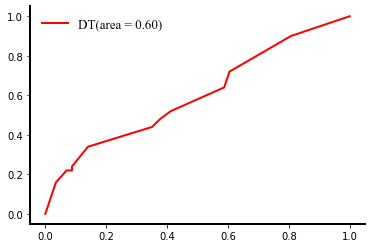

AUC of DT 0.6007894736842105
ACC of DT 0.5670731707317073
F1_score of DT 0.4227642276422764


In [4]:
#caculate the AUC,Acc,F1_score in the test cohort
Tuned_DT_model = joblib.load('best_DT_model')
y_proba = Tuned_DT_model.predict_proba(X_test)[:,1]
y_probability[0] = y_proba
y_pred = Tuned_DT_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
DT_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='DT(area = {0:.2f})'.format(DT_auc), c='r',lw=2)
plt.legend(prop={'family':'Times New Roman', 'size' : 13},frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

DT_acc = metrics.accuracy_score(y_test,y_pred)
DT_f1 = metrics.f1_score(y_test,y_pred)

print('AUC of DT',DT_auc)
print('ACC of DT',DT_acc)
print('F1_score of DT',DT_f1)



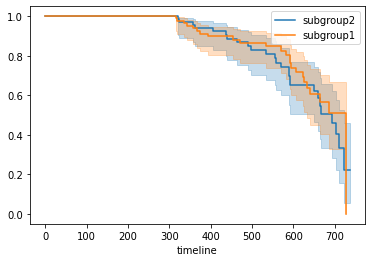

In [5]:
#comparsion of cumulative survival between subgroup1-whose predictive probability is greater than 0.5, 
#and subgroup2-whose predictive probability is smaller than 0.5
data_proba = pd.DataFrame(data=y_proba,index=X_test.index,columns=['y_proba'])
data_proba['Follow_up time'] = test['Follow_up time'].values
data_proba['MACE'] = test['MACE'].values
data_proba.sort_values(by='y_proba',ascending=False,inplace=True)
kmf = KaplanMeierFitter()
kmf.fit(data_proba[data_proba['y_proba']>=0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']>=0.5]['MACE'],label='subgroup2') 
ax = kmf.plot()
kmf.fit(data_proba[data_proba['y_proba']<0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']<0.5]['MACE'],label='subgroup1')

ax = kmf.plot(ax=ax)
DT_proba = data_proba
DT_proba.to_excel('DT_result.xlsx')

In [6]:
data_proba[data_proba['y_proba']>=0.5].shape

(73, 3)

Brier score of Decision tree before calibration: 0.2974997637641923
Brier score of Decision tree after calibration: 0.1935375977823912


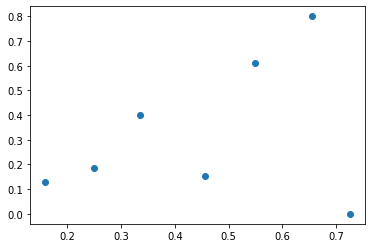

In [7]:
#caculate the brier_score of decision tree before calibration
DT_BS = metrics.brier_score_loss(y_test,y_proba,pos_label=1)
#model calibration
calibrated_DT  = joblib.load('calibrate_DT')
cal_probability = calibrated_DT.predict_proba(X_test)[:,1]
#caculate the brier_score of decision tree after calibration
Cal_DT_BS = metrics.brier_score_loss(y_test,cal_probability,pos_label=1)
print('Brier score of Decision tree before calibration:',DT_BS)

print('Brier score of Decision tree after calibration:',Cal_DT_BS)

fraction_of_positives[0], mean_predicted_value[0] = calibration_curve(y_test,cal_probability,n_bins=10)
plt.scatter(mean_predicted_value[0],fraction_of_positives[0])

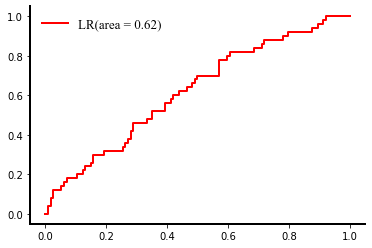

AUC of LR 0.6189473684210526
ACC of LR 0.5487804878048781
F1_score of LR 0.48611111111111105


In [8]:
#caculate the AUC,Acc,F1_score of logistic regression in the test cohort
Tuned_LR_model = joblib.load('best_LR_model')
y_proba = Tuned_LR_model.predict_proba(X_test)[:,1]
y_probability[1] = y_proba
y_pred = Tuned_LR_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
LR_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label='LR(area = {0:.2f})'.format(LR_auc), c='r',lw=2)
plt.legend(prop={'family':'Times New Roman', 'size' : 13},frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

LR_acc = metrics.accuracy_score(y_test,y_pred)
LR_f1 = metrics.f1_score(y_test,y_pred)

print('AUC of LR',LR_auc)
print('ACC of LR',LR_acc)
print('F1_score of LR',LR_f1)

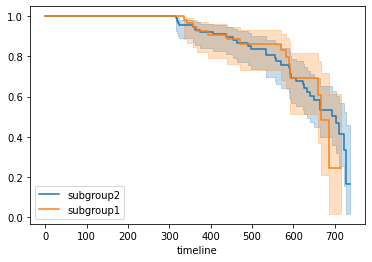

In [9]:
#comparsion of cumulative survival between subgroup1-whose predictive probability is greater than 0.5, 
#and subgroup2-whose predictive probability is smaller than 0.5 in the logistic regression 
data_proba = pd.DataFrame(data=y_proba,index=X_test.index,columns=['y_proba'])
data_proba['Follow_up time'] = test['Follow_up time'].values
data_proba['MACE'] = test['MACE'].values
data_proba.sort_values(by='y_proba',ascending=False,inplace=True)
kmf = KaplanMeierFitter()
kmf.fit(data_proba[data_proba['y_proba']>=0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']>=0.5]['MACE'],label='subgroup2') 
ax = kmf.plot()
kmf.fit(data_proba[data_proba['y_proba']<0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']<0.5]['MACE'],label='subgroup1')

ax = kmf.plot(ax=ax)

LR_proba = data_proba
LR_proba.to_excel('LR_result.xlsx')

Brier score of logistic regression  before calibration: 0.27376077568792523
Brier score of logistic regression after calibration: 0.23640802104545566


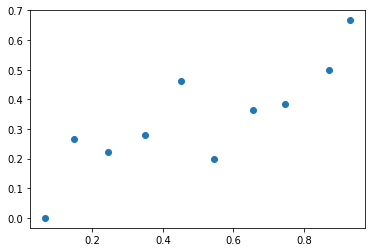

In [10]:
#caculate the brier_score of logistic regression  before calibration
LR_BS = metrics.brier_score_loss(y_test,y_proba,pos_label=1)
#model calibration
calibrated_LR  = joblib.load('calibrate_LR')
cal_probability = calibrated_LR.predict_proba(X_test)[:,1]
#caculate the brier_score of logistic regression after calibration
Cal_LR_BS = metrics.brier_score_loss(y_test,cal_probability,pos_label=1)
print('Brier score of logistic regression  before calibration:',LR_BS)

print('Brier score of logistic regression after calibration:',Cal_LR_BS)

fraction_of_positives[1], mean_predicted_value[1] = calibration_curve(y_test,cal_probability,n_bins=10)
plt.scatter(mean_predicted_value[1],fraction_of_positives[1])

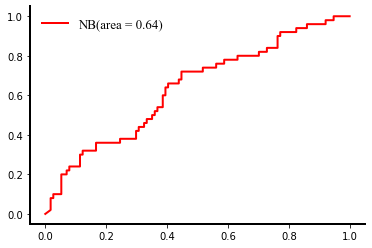

AUC of NB 0.6357894736842105
ACC of NB 0.6158536585365854
F1_score of NB 0.48611111111111105


In [11]:
#caculate the AUC,Acc,F1_score of Naive Bayes in the test cohort
Tuned_NB_model = joblib.load('best_NB_model')
y_proba = Tuned_NB_model.predict_proba(X_test)[:,1]
y_probability[2] = y_proba
y_pred = Tuned_NB_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
NB_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label='NB(area = {0:.2f})'.format(NB_auc), c='r',lw=2)
plt.legend(prop={'family':'Times New Roman', 'size' : 13},frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

NB_acc = metrics.accuracy_score(y_test,y_pred)
NB_f1 = metrics.f1_score(y_test,y_pred)

print('AUC of NB',NB_auc)
print('ACC of NB',NB_acc)
print('F1_score of NB',LR_f1)

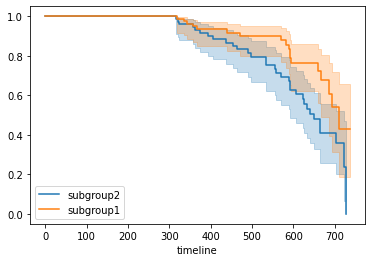

In [12]:
#comparsion of cumulative survival between subgroup1-whose predictive probability is greater than 0.5, 
#and subgroup2-whose predictive probability is smaller than 0.5 in the Naive Bayes 
data_proba = pd.DataFrame(data=y_proba,index=X_test.index,columns=['y_proba'])
data_proba['Follow_up time'] = test['Follow_up time'].values
data_proba['MACE'] = test['MACE'].values
data_proba.sort_values(by='y_proba',ascending=False,inplace=True)
kmf = KaplanMeierFitter()
kmf.fit(data_proba[data_proba['y_proba']>=0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']>=0.5]['MACE'],label='subgroup2') 
ax = kmf.plot()
kmf.fit(data_proba[data_proba['y_proba']<0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']<0.5]['MACE'],label='subgroup1')

ax = kmf.plot(ax=ax)
NB_proba = data_proba
NB_proba.to_excel('NB_result.xlsx')

Brier score of Naive Bayes before calibration: 0.3035927261963572
Brier score of Naive Bayes after calibration: 0.2341672347258646


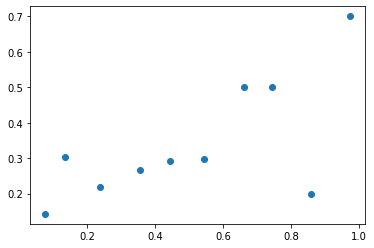

In [13]:
#caculate the brier_score of Naive Bayes  before calibration
NB_BS = metrics.brier_score_loss(y_test,y_proba,pos_label=1)
#model calibration
calibrated_NB  = joblib.load('calibrate_NB')
cal_probability = calibrated_NB.predict_proba(X_test)[:,1]
#caculate the brier_score of Naive Bayes after calibration
Cal_NB_BS = metrics.brier_score_loss(y_test,cal_probability,pos_label=1)
print('Brier score of Naive Bayes before calibration:',NB_BS)

print('Brier score of Naive Bayes after calibration:',Cal_NB_BS)

fraction_of_positives[2], mean_predicted_value[2] = calibration_curve(y_test,cal_probability,n_bins=10)
plt.scatter(mean_predicted_value[2],fraction_of_positives[2])

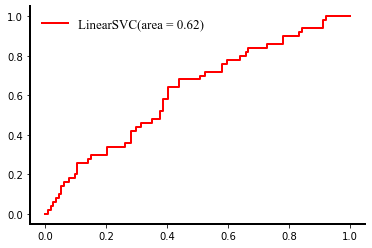

AUC of LinearSVC 0.6196491228070174
ACC of LinearSVC 0.5670731707317073
F1_score of LinearSVC 0.4892086330935252


In [14]:
#caculate the AUC,Acc,F1_score of LinearSVC in the test cohort
Tuned_LinearSVC_model = joblib.load('best_LinearSVC_model')
y_proba = Tuned_LinearSVC_model.decision_function(X_test)
y_proba = \
    (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
y_probability[3] = y_proba
y_pred = Tuned_LinearSVC_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
LinearSVC_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label='LinearSVC(area = {0:.2f})'.format(LinearSVC_auc), c='r',lw=2)
plt.legend(prop={'family':'Times New Roman', 'size' : 13},frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

LinearSVC_acc = metrics.accuracy_score(y_test,y_pred)
LinearSVC_f1 = metrics.f1_score(y_test,y_pred)

print('AUC of LinearSVC',LinearSVC_auc)
print('ACC of LinearSVC',LinearSVC_acc)
print('F1_score of LinearSVC',LinearSVC_f1)

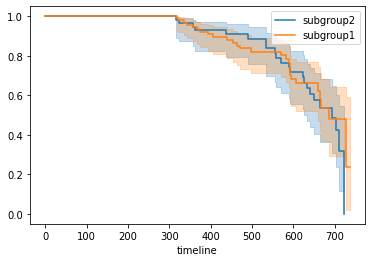

In [15]:
#comparsion of cumulative survival between subgroup1-whose predictive probability is greater than 0.5, 
#and subgroup2-whose predictive probability is smaller than 0.5 in the LinearSVC
data_proba = pd.DataFrame(data=y_proba,index=X_test.index,columns=['y_proba'])
data_proba['Follow_up time'] = test['Follow_up time'].values
data_proba['MACE'] = test['MACE'].values
data_proba.sort_values(by='y_proba',ascending=False,inplace=True)
kmf = KaplanMeierFitter()
kmf.fit(data_proba[data_proba['y_proba']>=0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']>=0.5]['MACE'],label='subgroup2') 
ax = kmf.plot()
kmf.fit(data_proba[data_proba['y_proba']<0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']<0.5]['MACE'],label='subgroup1')

ax = kmf.plot(ax=ax)
LinearSVC_proba = data_proba
LinearSVC_proba.to_excel('SVC_result.xlsx')

Brier score of LinearSVC before calibration: 0.23411340733497044
Brier score of LinearSVC after calibration: 0.2341672347258646


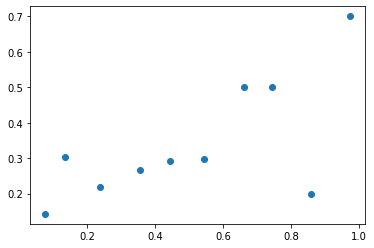

In [16]:
#caculate the brier_score of LinearSVC  before calibration
LinearSVC_BS = metrics.brier_score_loss(y_test,y_proba,pos_label=1)
#model calibration
calibrated_LinearSVC = joblib.load('calibrate_NB')
cal_probability = calibrated_NB.predict_proba(X_test)[:,1]
#caculate the brier_score of Naive Bayes after calibration
Cal_LinearSVC_BS = metrics.brier_score_loss(y_test,cal_probability,pos_label=1)
print('Brier score of LinearSVC before calibration:',LinearSVC_BS)

print('Brier score of LinearSVC after calibration:',Cal_LinearSVC_BS )

fraction_of_positives[3], mean_predicted_value[3] = calibration_curve(y_test,cal_probability,n_bins=10)
plt.scatter(mean_predicted_value[3],fraction_of_positives[3])

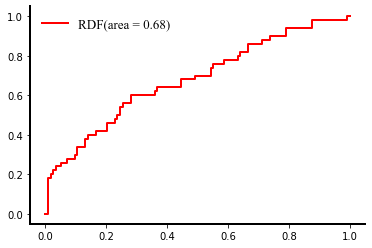

AUC of RDF 0.6789473684210526
ACC of RDF 0.6829268292682927
F1_score of RDF 0.48


In [17]:
#caculate the AUC,Acc,F1_score of Random forest in the test cohort
Tuned_RDF_model = joblib.load('best_RDF_model')
y_proba = Tuned_RDF_model.predict_proba(X_test)[:,1]
'''
y_proba = \
    (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
'''
y_probability[4] = y_proba
y_pred = Tuned_RDF_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
RDF_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label='RDF(area = {0:.2f})'.format(RDF_auc), c='r',lw=2)
plt.legend(prop={'family':'Times New Roman', 'size' : 13},frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

RDF_acc = metrics.accuracy_score(y_test,y_pred)
RDF_f1 = metrics.f1_score(y_test,y_pred)

print('AUC of RDF',RDF_auc)
print('ACC of RDF',RDF_acc)
print('F1_score of RDF',RDF_f1)

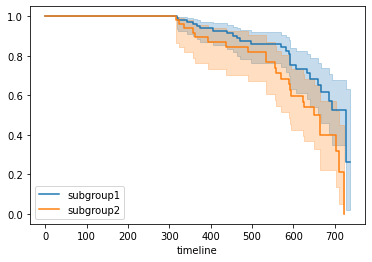

In [18]:
#comparsion of cumulative survival between subgroup1-whose predictive probability is greater than 0.5, 
#and subgroup2-whose predictive probability is smaller than 0.5 in the RDF
data_proba = pd.DataFrame(data=y_proba,index=X_test.index,columns=['y_proba'])
data_proba['Follow_up time'] = test['Follow_up time'].values
data_proba['MACE'] = test['MACE'].values
data_proba.sort_values(by='y_proba',ascending=False,inplace=True)
kmf = KaplanMeierFitter()
kmf.fit(data_proba[data_proba['y_proba']<0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']<0.5]['MACE'],label='subgroup1')
ax = kmf.plot()
kmf.fit(data_proba[data_proba['y_proba']>=0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']>=0.5]['MACE'],label='subgroup2') 
ax = kmf.plot(ax=ax)
RDF_proba = data_proba
RDF_proba.to_excel('RDF_result.xlsx')

Brier score of RDF before calibration: 0.2094324685415727
Brier score of RDF after calibration: 0.21911653184862517


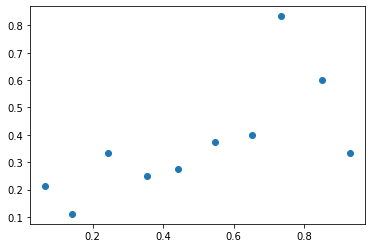

In [19]:
#caculate the brier_score of RDF  before calibration
RDF_BS = metrics.brier_score_loss(y_test,y_proba,pos_label=1)
#model calibration
calibrated_RDF = joblib.load('calibrate_RDF')
cal_probability = calibrated_RDF.predict_proba(X_test)[:,1]
#caculate the brier_score of RDF after calibration
Cal_RDF_BS = metrics.brier_score_loss(y_test,cal_probability,pos_label=1)
print('Brier score of RDF before calibration:',RDF_BS)

print('Brier score of RDF after calibration:',Cal_RDF_BS)

fraction_of_positives[4], mean_predicted_value[4] = calibration_curve(y_test,cal_probability,n_bins=10)
plt.scatter(mean_predicted_value[4],fraction_of_positives[4])

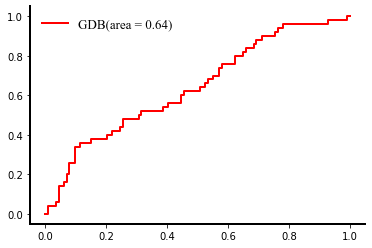

AUC of GDB 0.6408771929824562
ACC of GDB 0.6829268292682927
F1_score of GDB 0.4222222222222222


In [20]:
#caculate the AUC,Acc,F1_score of Gradient Boosting in the test cohort
Tuned_GDB_model = joblib.load('best_GDB_model')
y_proba = Tuned_GDB_model.predict_proba(X_test)[:,1]
'''
y_proba = \
    (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
'''
y_probability[5] = y_proba
y_pred = Tuned_GDB_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
GDB_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label='GDB(area = {0:.2f})'.format(GDB_auc), c='r',lw=2)
plt.legend(prop={'family':'Times New Roman', 'size' : 13},frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

GDB_acc = metrics.accuracy_score(y_test,y_pred)
GDB_f1 = metrics.f1_score(y_test,y_pred)

print('AUC of GDB',GDB_auc)
print('ACC of GDB',GDB_acc)
print('F1_score of GDB',GDB_f1)

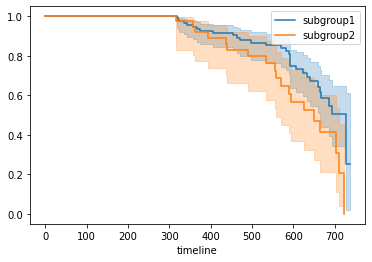

In [21]:
#comparsion of cumulative survival between subgroup1-whose predictive probability is greater than 0.5, 
#and subgroup2-whose predictive probability is smaller than 0.5 in the GDB
data_proba = pd.DataFrame(data=y_proba,index=X_test.index,columns=['y_proba'])
data_proba['Follow_up time'] = test['Follow_up time'].values
data_proba['MACE'] = test['MACE'].values
data_proba.sort_values(by='y_proba',ascending=False,inplace=True)
kmf = KaplanMeierFitter()
kmf.fit(data_proba[data_proba['y_proba']<0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']<0.5]['MACE'],label='subgroup1')
ax = kmf.plot()
kmf.fit(data_proba[data_proba['y_proba']>=0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']>=0.5]['MACE'],label='subgroup2') 
ax = kmf.plot(ax=ax)
GDB_proba = data_proba
GDB_proba.to_excel('GDB_result.xlsx')

Brier score of GDB before calibration: 0.21951926946340164
Brier score of GDB after calibration: 0.22266322999253263


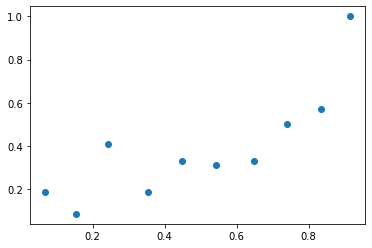

In [22]:
#caculate the brier_score of GDB  before calibration
GDB_BS = metrics.brier_score_loss(y_test,y_proba,pos_label=1)
#model calibration
calibrated_GDB = joblib.load('calibrate_GDB')
cal_probability = calibrated_GDB.predict_proba(X_test)[:,1]
#caculate the brier_score of GDB after calibration
Cal_GDB_BS = metrics.brier_score_loss(y_test,cal_probability,pos_label=1)
print('Brier score of GDB before calibration:',GDB_BS)

print('Brier score of GDB after calibration:',Cal_GDB_BS)

fraction_of_positives[5], mean_predicted_value[5] = calibration_curve(y_test,cal_probability,n_bins=10)
plt.scatter(mean_predicted_value[5],fraction_of_positives[5])

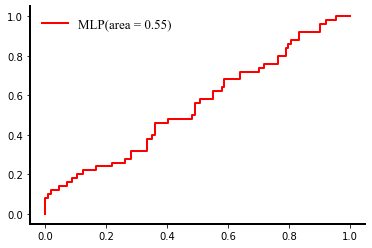

AUC of MLP 0.5482456140350878
ACC of MLP 0.6951219512195121
F1_score of MLP 0.0


In [23]:
#caculate the AUC,Acc,F1_score of Multilayer perceptron in the test cohort
Tuned_MLP_model = load_model('Best_MLP_Model.h5')
y_proba = Tuned_MLP_model.predict(X_test)
'''
y_proba = \
    (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
'''
y_probability[6] = y_proba
y_pred = np.argmax(y_proba,axis=1)
fpr, tpr, thresholds = roc_curve(y_test, y_proba,pos_label=1)
MLP_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label='MLP(area = {0:.2f})'.format(MLP_auc), c='r',lw=2)
plt.legend(prop={'family':'Times New Roman', 'size' : 13},frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

MLP_acc = metrics.accuracy_score(y_test,y_pred)
MLP_f1 = metrics.f1_score(y_test,y_pred)

print('AUC of MLP',MLP_auc)
print('ACC of MLP',MLP_acc)
print('F1_score of MLP',MLP_f1)

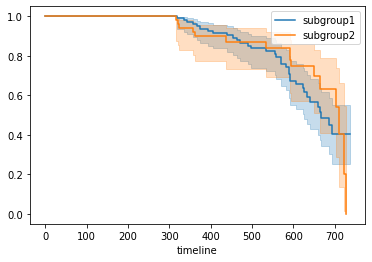

In [24]:
#comparsion of cumulative survival between subgroup1-whose predictive probability is greater than 0.5, 
#and subgroup2-whose predictive probability is smaller than 0.5 in the MLP
data_proba = pd.DataFrame(data=y_proba,index=X_test.index,columns=['y_proba'])
data_proba['Follow_up time'] = test['Follow_up time'].values
data_proba['MACE'] = test['MACE'].values
data_proba.sort_values(by='y_proba',ascending=False,inplace=True)
kmf = KaplanMeierFitter()
kmf.fit(data_proba[data_proba['y_proba']<0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']<0.5]['MACE'],label='subgroup1')
ax = kmf.plot()
kmf.fit(data_proba[data_proba['y_proba']>=0.5]['Follow_up time'], 
        data_proba[data_proba['y_proba']>=0.5]['MACE'],label='subgroup2') 
ax = kmf.plot(ax=ax)
MLP_proba = data_proba
MLP_proba.to_excel('MLP_result.xlsx')

7/7 [==============================] - 0s 2ms/step - loss: 0.6490 - accuracy: 0.6378
Brier score of MLP before calibration: 0.2405770254675197
Brier score of MLP after calibration: 0.3231707317073171


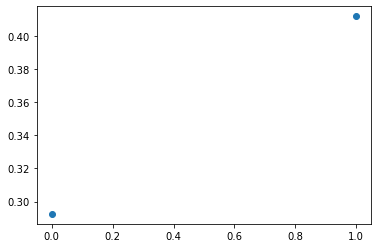

In [25]:

##calibration for MLP
import tensorflow as tf
np.random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

def calibration_model():
    model = models.Sequential()
    model.add(layers.Dense(15,activation='relu',input_shape=(24,)))
    model.add(layers.Dense(1,activation='sigmoid'))
    sgd = SGD(learning_rate=1,momentum=0.8)
    model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
    return model
MLP_model = KerasClassifier(calibration_model,batch_size=28,nb_epoch=15)
isotonic = CalibratedClassifierCV(MLP_model, cv=5, method='isotonic')
X_train = np.load('X.npy')
y_train = np.load('y.npy')
isotonic.fit(X_train,y_train)

#caculate the brier_score of MLP  before calibration
MLP_BS = metrics.brier_score_loss(y_test,y_proba,pos_label=1)

#model calibration
cal_probability = isotonic.predict(X_test)
#caculate the brier_score of MLP after calibration
Cal_MLP_BS = metrics.brier_score_loss(y_test,cal_probability,pos_label=1)

print('Brier score of MLP before calibration:',MLP_BS)
print('Brier score of MLP after calibration:',Cal_MLP_BS)

fraction_of_positives[6], mean_predicted_value[6] = calibration_curve(y_test,cal_probability,n_bins=10)
plt.scatter(mean_predicted_value[6],fraction_of_positives[6])

In [26]:
print(mean_predicted_value[6])
print(fraction_of_positives[6])

[0. 1.]
[0.29251701 0.41176471]


C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator


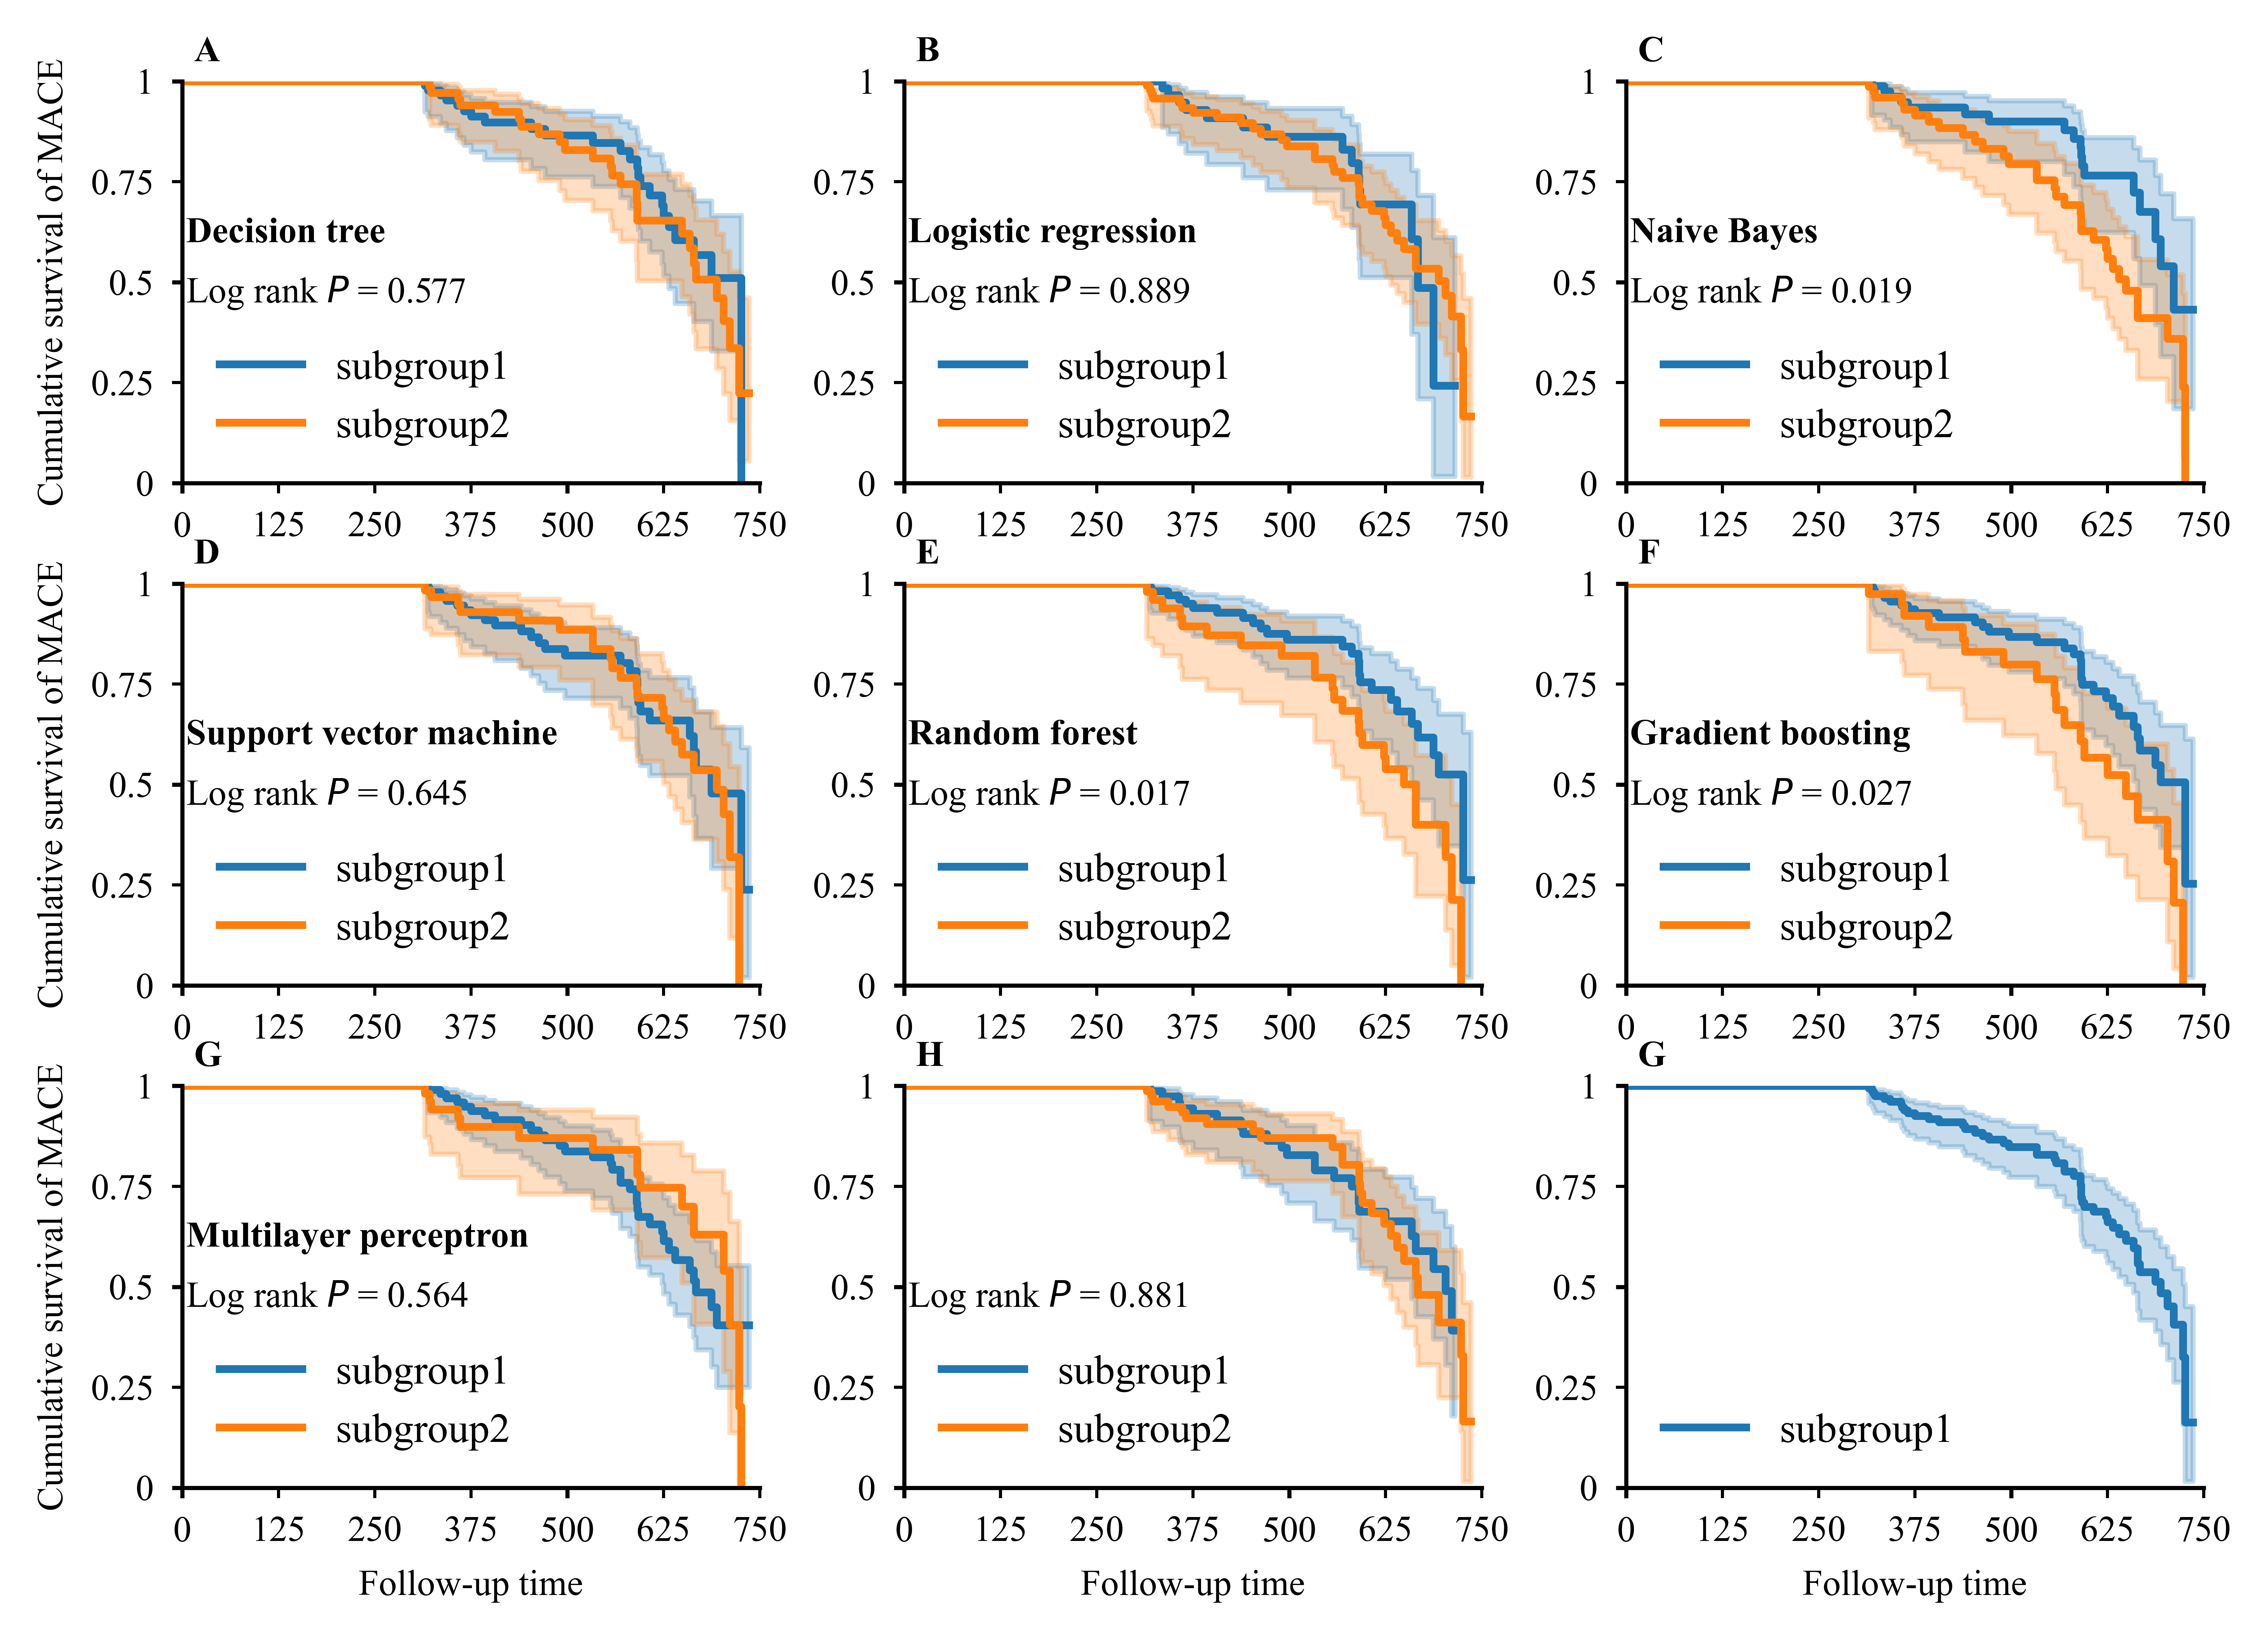

In [25]:
#K_M survival analysis 
import matplotlib
import matplotlib.gridspec as grd
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
plt.figure(figsize=(7,5),dpi=1200)
ax0 = plt.subplot(331)
ax1 = plt.subplot(332)
ax2 = plt.subplot(333)
ax3 = plt.subplot(334)
ax4 = plt.subplot(335)
ax5 = plt.subplot(336)
ax6 = plt.subplot(337)
ax7 = plt.subplot(338)
ax8 = plt.subplot(339)
plt.subplots_adjust(wspace=0.25,hspace=0.25)

#Survival curve for DT   
kmf.fit(DT_proba[DT_proba['y_proba']<0.5]['Follow_up time'], 
        DT_proba[DT_proba['y_proba']<0.5]['MACE'],label='subgroup1')
kmf.plot(ax=ax0)
kmf.fit(DT_proba[DT_proba['y_proba']>=0.5]['Follow_up time'], 
        DT_proba[DT_proba['y_proba']>=0.5]['MACE'],label='subgroup2')
kmf.plot(ax=ax0)

#Survival curve for LR
kmf.fit(LR_proba[LR_proba['y_proba']<0.5]['Follow_up time'], 
        LR_proba[LR_proba['y_proba']<0.5]['MACE'],label='subgroup1')
kmf.plot(ax=ax1)
kmf.fit(LR_proba[LR_proba['y_proba']>=0.5]['Follow_up time'], 
        LR_proba[LR_proba['y_proba']>=0.5]['MACE'],label='subgroup2')
kmf.plot(ax=ax1)

#Survival curve for NB
kmf.fit(NB_proba[NB_proba['y_proba']<0.5]['Follow_up time'], 
        NB_proba[NB_proba['y_proba']<0.5]['MACE'],label='subgroup1')
kmf.plot(ax=ax2)
kmf.fit(NB_proba[NB_proba['y_proba']>=0.5]['Follow_up time'], 
        NB_proba[NB_proba['y_proba']>=0.5]['MACE'],label='subgroup2')
kmf.plot(ax=ax2)

#Survival curve for LinearSVC
kmf.fit(LinearSVC_proba[LinearSVC_proba['y_proba']<0.5]['Follow_up time'], 
        LinearSVC_proba[LinearSVC_proba['y_proba']<0.5]['MACE'],label='subgroup1')
kmf.plot(ax=ax3)
kmf.fit(LinearSVC_proba[LinearSVC_proba['y_proba']>=0.5]['Follow_up time'], 
        LinearSVC_proba[LinearSVC_proba['y_proba']>=0.5]['MACE'],label='subgroup2')
kmf.plot(ax=ax3)

#Survival curve for RDF
kmf.fit(RDF_proba[RDF_proba['y_proba']<0.5]['Follow_up time'], 
        RDF_proba[RDF_proba['y_proba']<0.5]['MACE'],label='subgroup1')
kmf.plot(ax=ax4)
kmf.fit(RDF_proba[RDF_proba['y_proba']>=0.5]['Follow_up time'], 
        RDF_proba[RDF_proba['y_proba']>=0.5]['MACE'],label='subgroup2')
kmf.plot(ax=ax4)


#Survival curve for GDB
kmf.fit(GDB_proba[GDB_proba['y_proba']<0.5]['Follow_up time'], 
        GDB_proba[GDB_proba['y_proba']<0.5]['MACE'],label='subgroup1')
kmf.plot(ax=ax5)
kmf.fit(GDB_proba[GDB_proba['y_proba']>=0.5]['Follow_up time'], 
        GDB_proba[GDB_proba['y_proba']>=0.5]['MACE'],label='subgroup2')
kmf.plot(ax=ax5)

#Survival curve for MLP
kmf.fit(MLP_proba[MLP_proba['y_proba']<0.5]['Follow_up time'], 
        MLP_proba[MLP_proba['y_proba']<0.5]['MACE'],label='subgroup1')
kmf.plot(ax=ax6)
kmf.fit(MLP_proba[MLP_proba['y_proba']>=0.5]['Follow_up time'], 
        MLP_proba[MLP_proba['y_proba']>=0.5]['MACE'],label='subgroup2')
kmf.plot(ax=ax6)

#Comparsion of survival between two random subgroups
test = test.reindex(np.random.permutation(test.index))

kmf.fit(test['Follow_up time'][0:82],test['MACE'][0:82],label='subgroup1')
kmf.plot(ax=ax7)
kmf.fit(test['Follow_up time'][82:],test['MACE'][82:],label='subgroup2')
kmf.plot(ax=ax7)

kmf.fit(test['Follow_up time'],test['MACE'],label='subgroup1')
kmf.plot(ax=ax8)

letter = ['A','B','C','D','E','F','G','H','G']
label = ['Decision tree','Logistic regression ','Naive Bayes','Support vector machine',
         'Random forest','Gradient boosting','Multilayer perceptron','','']
i = 0
for ax in [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylim(0,1)
    ax.set_xlim(0,750)
    
    ax.legend(prop={'family':'Times New Roman','size':8},frameon=False)
    xmajorlocator = MultipleLocator(500)
    ax.xaxis.set_major_locator(xmajorlocator)
    xminorlocator = MultipleLocator(125)
    ax.xaxis.set_minor_locator(xminorlocator)

    ymajorlocator = MultipleLocator(0.5)
    ax.yaxis.set_major_locator(ymajorlocator)
    yminorlocator = MultipleLocator(0.25)
    ax.yaxis.set_minor_locator(yminorlocator)

    yminorformatter = FormatStrFormatter('%0.2f')
    xminorformatter = FormatStrFormatter('%0.0f')
    ax.xaxis.set_minor_formatter(xminorformatter)
    ax.yaxis.set_minor_formatter(yminorformatter)

    ax.xaxis.set_tick_params(which='major',length=2,labelsize=7)
    ax.xaxis.set_tick_params(which='minor',length=2,labelsize=7)
    ax.yaxis.set_tick_params(which='major',length=2,labelsize=7)
    ax.yaxis.set_tick_params(which='minor',length=2,labelsize=7)

    ax.xaxis.set_ticklabels(ticklabels=['0','0','500'],minor=False,family='Times New Roman')
    ax.xaxis.set_ticklabels(ticklabels=['0','125','250','375','625','750'],minor=True,family='Times New Roman')
    ax.yaxis.set_ticklabels(ticklabels=['0','0','0.5','1'],minor=False,family='Times New Roman')
    ax.yaxis.set_ticklabels(ticklabels=['0','0.25','0.75'],minor=True,family='Times New Roman')
    
    ax.set_xlabel('',fontdict={'family': 'Times New Roman','size': 0})

    ax.text(15,1.05,letter[i],fontproperties = 'Times New Roman', size = 7,fontweight='bold')
    ax.text(5,0.6,label[i],fontproperties = 'Times New Roman', size = 7,fontweight='bold')
    i+=1

for ax in [ax6,ax7,ax8]:
    ax.set_xlabel('Follow-up time',fontdict={'family': 'Times New Roman','size': 7})
for ax in [ax0,ax3,ax6]:
    ax.set_ylabel('Cumulative survival of MACE',fontdict={'family': 'Times New Roman','size': 7}) 

#Log rank P was calculated using SPSS    
ax0.text(5,0.45,'Log rank $\mathregular{\mathit{P}}$ = 0.577',fontproperties = 'Times New Roman', size = 7)
ax1.text(5,0.45,'Log rank $\mathregular{\mathit{P}}$ = 0.889',fontproperties = 'Times New Roman', size = 7)
ax2.text(5,0.45,'Log rank $\mathregular{\mathit{P}}$ = 0.019',fontproperties = 'Times New Roman', size = 7)
ax3.text(5,0.45,'Log rank $\mathregular{\mathit{P}}$ = 0.645',fontproperties = 'Times New Roman', size = 7)
ax4.text(5,0.45,'Log rank $\mathregular{\mathit{P}}$ = 0.017',fontproperties = 'Times New Roman', size = 7)
ax5.text(5,0.45,'Log rank $\mathregular{\mathit{P}}$ = 0.027',fontproperties = 'Times New Roman', size = 7)
ax6.text(5,0.45,'Log rank $\mathregular{\mathit{P}}$ = 0.564',fontproperties = 'Times New Roman', size = 7)
ax7.text(5,0.45,'Log rank $\mathregular{\mathit{P}}$ = 0.881',fontproperties = 'Times New Roman', size = 7)
#plt.savefig('pic5.jpg',dpi=1200)
plt.show()

C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator


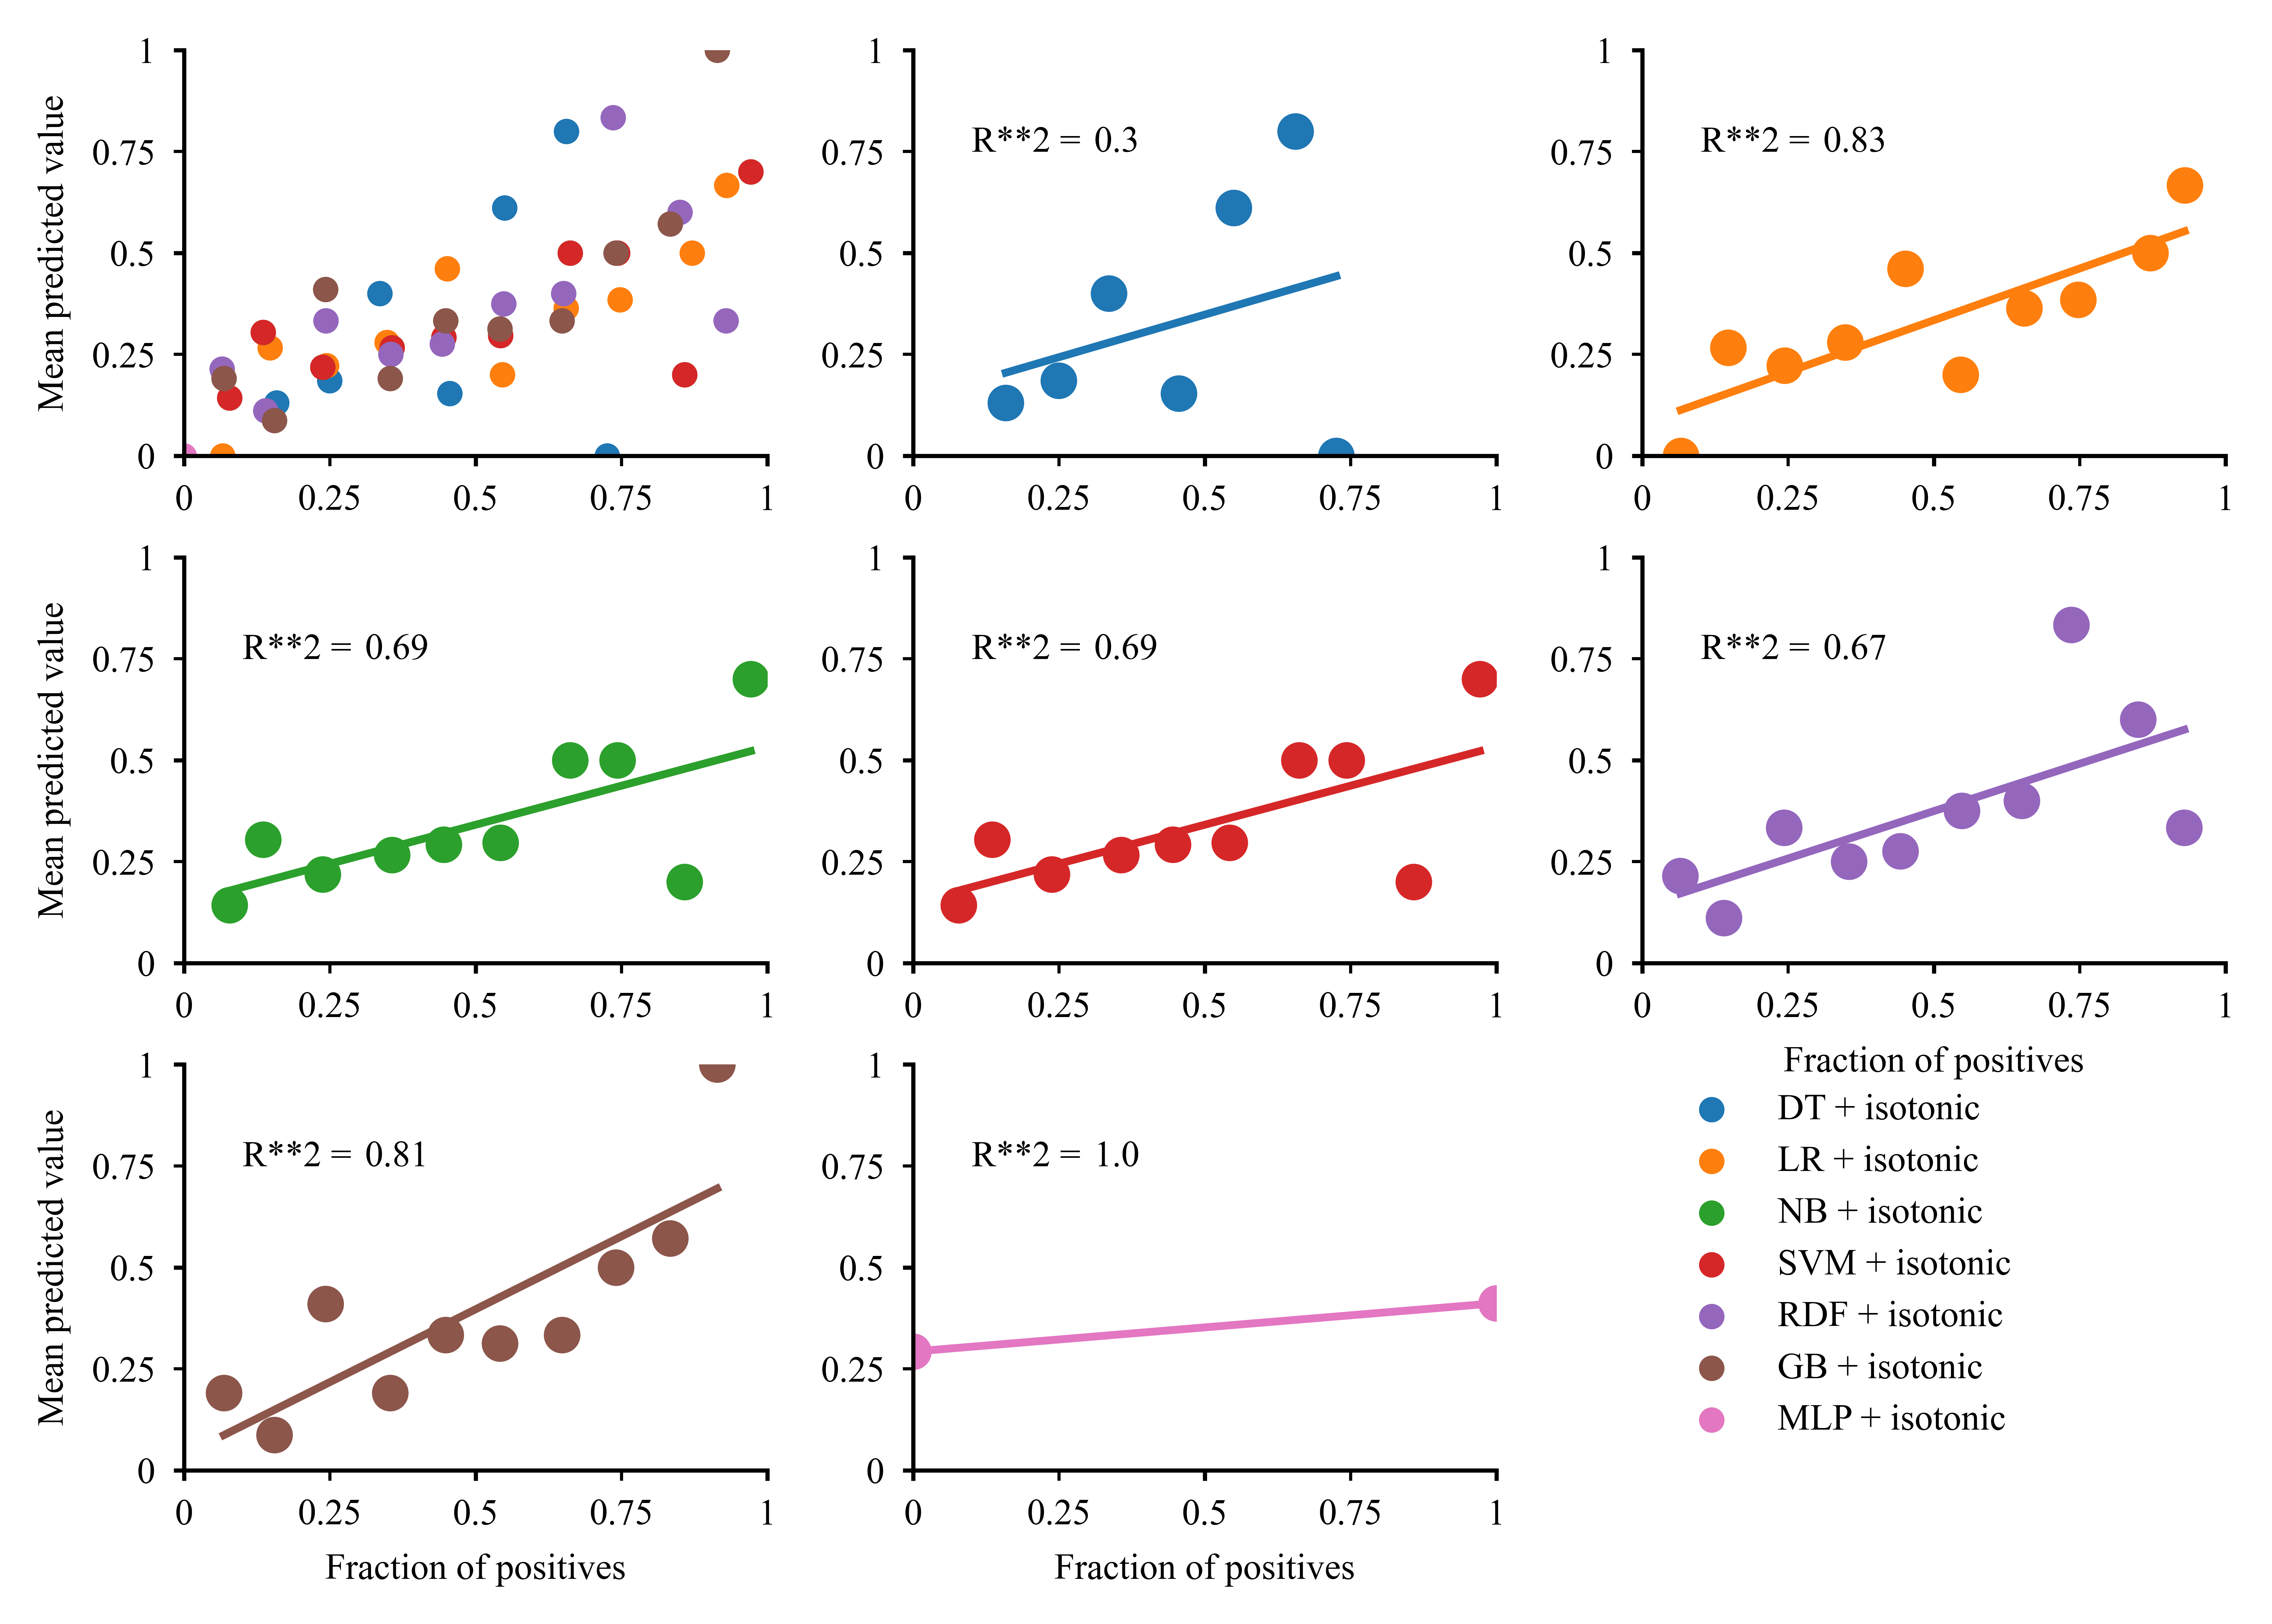

In [26]:
from numpy import polyfit,poly1d
from scipy import stats
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
plt.figure(figsize=(7,5),dpi=1200)
ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)
ax6 = plt.subplot(336)
ax7 = plt.subplot(337)
ax8 = plt.subplot(338)
ax9 = plt.subplot(339)
plt.subplots_adjust(wspace=0.25,hspace=0.25)

ax1.set_xlim(0.0,1.0)
ax1.set_ylim(0.0,1.0)
L1 = ax1.scatter(mean_predicted_value[0],fraction_of_positives[0],s=15)
L2 = ax1.scatter(mean_predicted_value[1],fraction_of_positives[1],s=15)
L3 = ax1.scatter(mean_predicted_value[2],fraction_of_positives[2],s=15)
L4 = ax1.scatter(mean_predicted_value[3],fraction_of_positives[3],s=15)
L5 = ax1.scatter(mean_predicted_value[4],fraction_of_positives[4],s=15)
L6 = ax1.scatter(mean_predicted_value[5],fraction_of_positives[5],s=15)
L7 = ax1.scatter(mean_predicted_value[6],fraction_of_positives[6],s=15)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    
    xmajorlocator = MultipleLocator(0.5)
    ax.xaxis.set_major_locator(xmajorlocator)
    xminorlocator = MultipleLocator(0.25)
    ax.xaxis.set_minor_locator(xminorlocator)

    ymajorlocator = MultipleLocator(0.5)
    ax.yaxis.set_major_locator(ymajorlocator)
    yminorlocator = MultipleLocator(0.25)
    ax.yaxis.set_minor_locator(yminorlocator)

    yminorformatter = FormatStrFormatter('%0.2f')
    xminorformatter = FormatStrFormatter('%0.2f')
    ax.xaxis.set_minor_formatter(xminorformatter)
    ax.yaxis.set_minor_formatter(yminorformatter)

    ax.xaxis.set_tick_params(which='major',length=2,labelsize=7)
    ax.xaxis.set_tick_params(which='minor',length=2,labelsize=7)
    ax.yaxis.set_tick_params(which='major',length=2,labelsize=7)
    ax.yaxis.set_tick_params(which='minor',length=2,labelsize=7)

    ax.xaxis.set_ticklabels(ticklabels=['0','0','0.5','1'],minor=False,family='Times New Roman')
    ax.xaxis.set_ticklabels(ticklabels=['0','0.25','0.75'],minor=True,family='Times New Roman')
    ax.yaxis.set_ticklabels(ticklabels=['0','0','0.5','1'],minor=False,family='Times New Roman')
    ax.yaxis.set_ticklabels(ticklabels=['0','0.25','0.75'],minor=True,family='Times New Roman')
    
ax2.scatter(mean_predicted_value[0],fraction_of_positives[0],color='#1f77b4')
coeff = polyfit(mean_predicted_value[0],fraction_of_positives[0],1)
f = poly1d(coeff)
x = mean_predicted_value[0]
ax2.plot(x, f(x),'#1f77b4')
square_R = stats.linregress(mean_predicted_value[0],fraction_of_positives[0]).rvalue
ax2.text(0.1,0.75,'R**2 =',fontproperties = 'Times New Roman', size = 7)
ax2.text(0.31,0.75,round(square_R,2),fontproperties = 'Times New Roman', size = 7)

ax3.scatter(mean_predicted_value[1],fraction_of_positives[1],color='#ff7f0e')
coeff = polyfit(mean_predicted_value[1],fraction_of_positives[1],1)
f = poly1d(coeff)
x = mean_predicted_value[1]
ax3.plot(x, f(x),'#ff7f0e')
square_R = stats.linregress(mean_predicted_value[1],fraction_of_positives[1]).rvalue
ax3.text(0.1,0.75,'R**2 =',fontproperties = 'Times New Roman', size = 7)
ax3.text(0.31,0.75,round(square_R,2),fontproperties = 'Times New Roman', size = 7)

ax4.scatter(mean_predicted_value[2],fraction_of_positives[2],color='#2ca02c')
coeff = polyfit(mean_predicted_value[2],fraction_of_positives[2],1)
f = poly1d(coeff)
x = mean_predicted_value[2]
ax4.plot(x, f(x),'#2ca02c')
square_R = stats.linregress(mean_predicted_value[2],fraction_of_positives[2]).rvalue
ax4.text(0.1,0.75,'R**2 =',fontproperties = 'Times New Roman', size = 7)
ax4.text(0.31,0.75,round(square_R,2),fontproperties = 'Times New Roman', size = 7)

ax5.scatter(mean_predicted_value[3],fraction_of_positives[3],color='#d62728')
coeff = polyfit(mean_predicted_value[3],fraction_of_positives[3],1)
f = poly1d(coeff)
x = mean_predicted_value[3]
ax5.plot(x, f(x),'#d62728')
square_R = stats.linregress(mean_predicted_value[3],fraction_of_positives[3]).rvalue
ax5.text(0.1,0.75,'R**2 =',fontproperties = 'Times New Roman', size = 7)
ax5.text(0.31,0.75,round(square_R,2),fontproperties = 'Times New Roman', size = 7)

ax6.scatter(mean_predicted_value[4],fraction_of_positives[4],color='#9467bd')
coeff = polyfit(mean_predicted_value[4],fraction_of_positives[4],1)
f = poly1d(coeff)
x = mean_predicted_value[4]
ax6.plot(x, f(x),'#9467bd')
square_R = stats.linregress(mean_predicted_value[4],fraction_of_positives[4]).rvalue
ax6.text(0.1,0.75,'R**2 =',fontproperties = 'Times New Roman', size = 7)
ax6.text(0.31,0.75,round(square_R,2),fontproperties = 'Times New Roman', size = 7)

ax7.scatter(mean_predicted_value[5],fraction_of_positives[5],color='#8c564b')
coeff = polyfit(mean_predicted_value[5],fraction_of_positives[5],1)
f = poly1d(coeff)
x = mean_predicted_value[5]
ax7.plot(x, f(x),'#8c564b')
square_R = stats.linregress(mean_predicted_value[5],fraction_of_positives[5]).rvalue
ax7.text(0.1,0.75,'R**2 =',fontproperties = 'Times New Roman', size = 7)
ax7.text(0.31,0.75,round(square_R,2),fontproperties = 'Times New Roman', size = 7)

ax8.scatter([0,1],[0.29251701,0.41176471],color='#e377c2')
coeff = polyfit([0,1],[0.29251701,0.41176471],1)
f = poly1d(coeff)
x = [0,1]
ax8.plot(x, f(x),'#e377c2')
square_R = stats.linregress([0,1],[0.29251701,0.41176471]).rvalue
ax8.text(0.1,0.75,'R**2 =',fontproperties = 'Times New Roman', size = 7)
ax8.text(0.31,0.75,round(square_R,2),fontproperties = 'Times New Roman', size = 7)

ax9.set_xticks([])
ax9.set_yticks([])
ax9.axis('off')
plt.legend([L1,L2,L3,L4,L5,L6,L7],['DT + isotonic','LR + isotonic','NB + isotonic',
                                   'SVM + isotonic','RDF + isotonic','GB + isotonic',
                                  'MLP + isotonic'],loc=3,prop={'family':'Times New Roman','size':7},frameon=False)
for ax in [ax6,ax7,ax8]:
    ax.set_xlabel('Fraction of positives',fontdict={'family': 'Times New Roman','size': 7})
for ax in [ax1,ax4,ax7]:
    ax.set_ylabel('Mean predicted value',fontdict={'family': 'Times New Roman','size': 7})
#plt.savefig('pic4.jpg',dpi=1200)
plt.show()

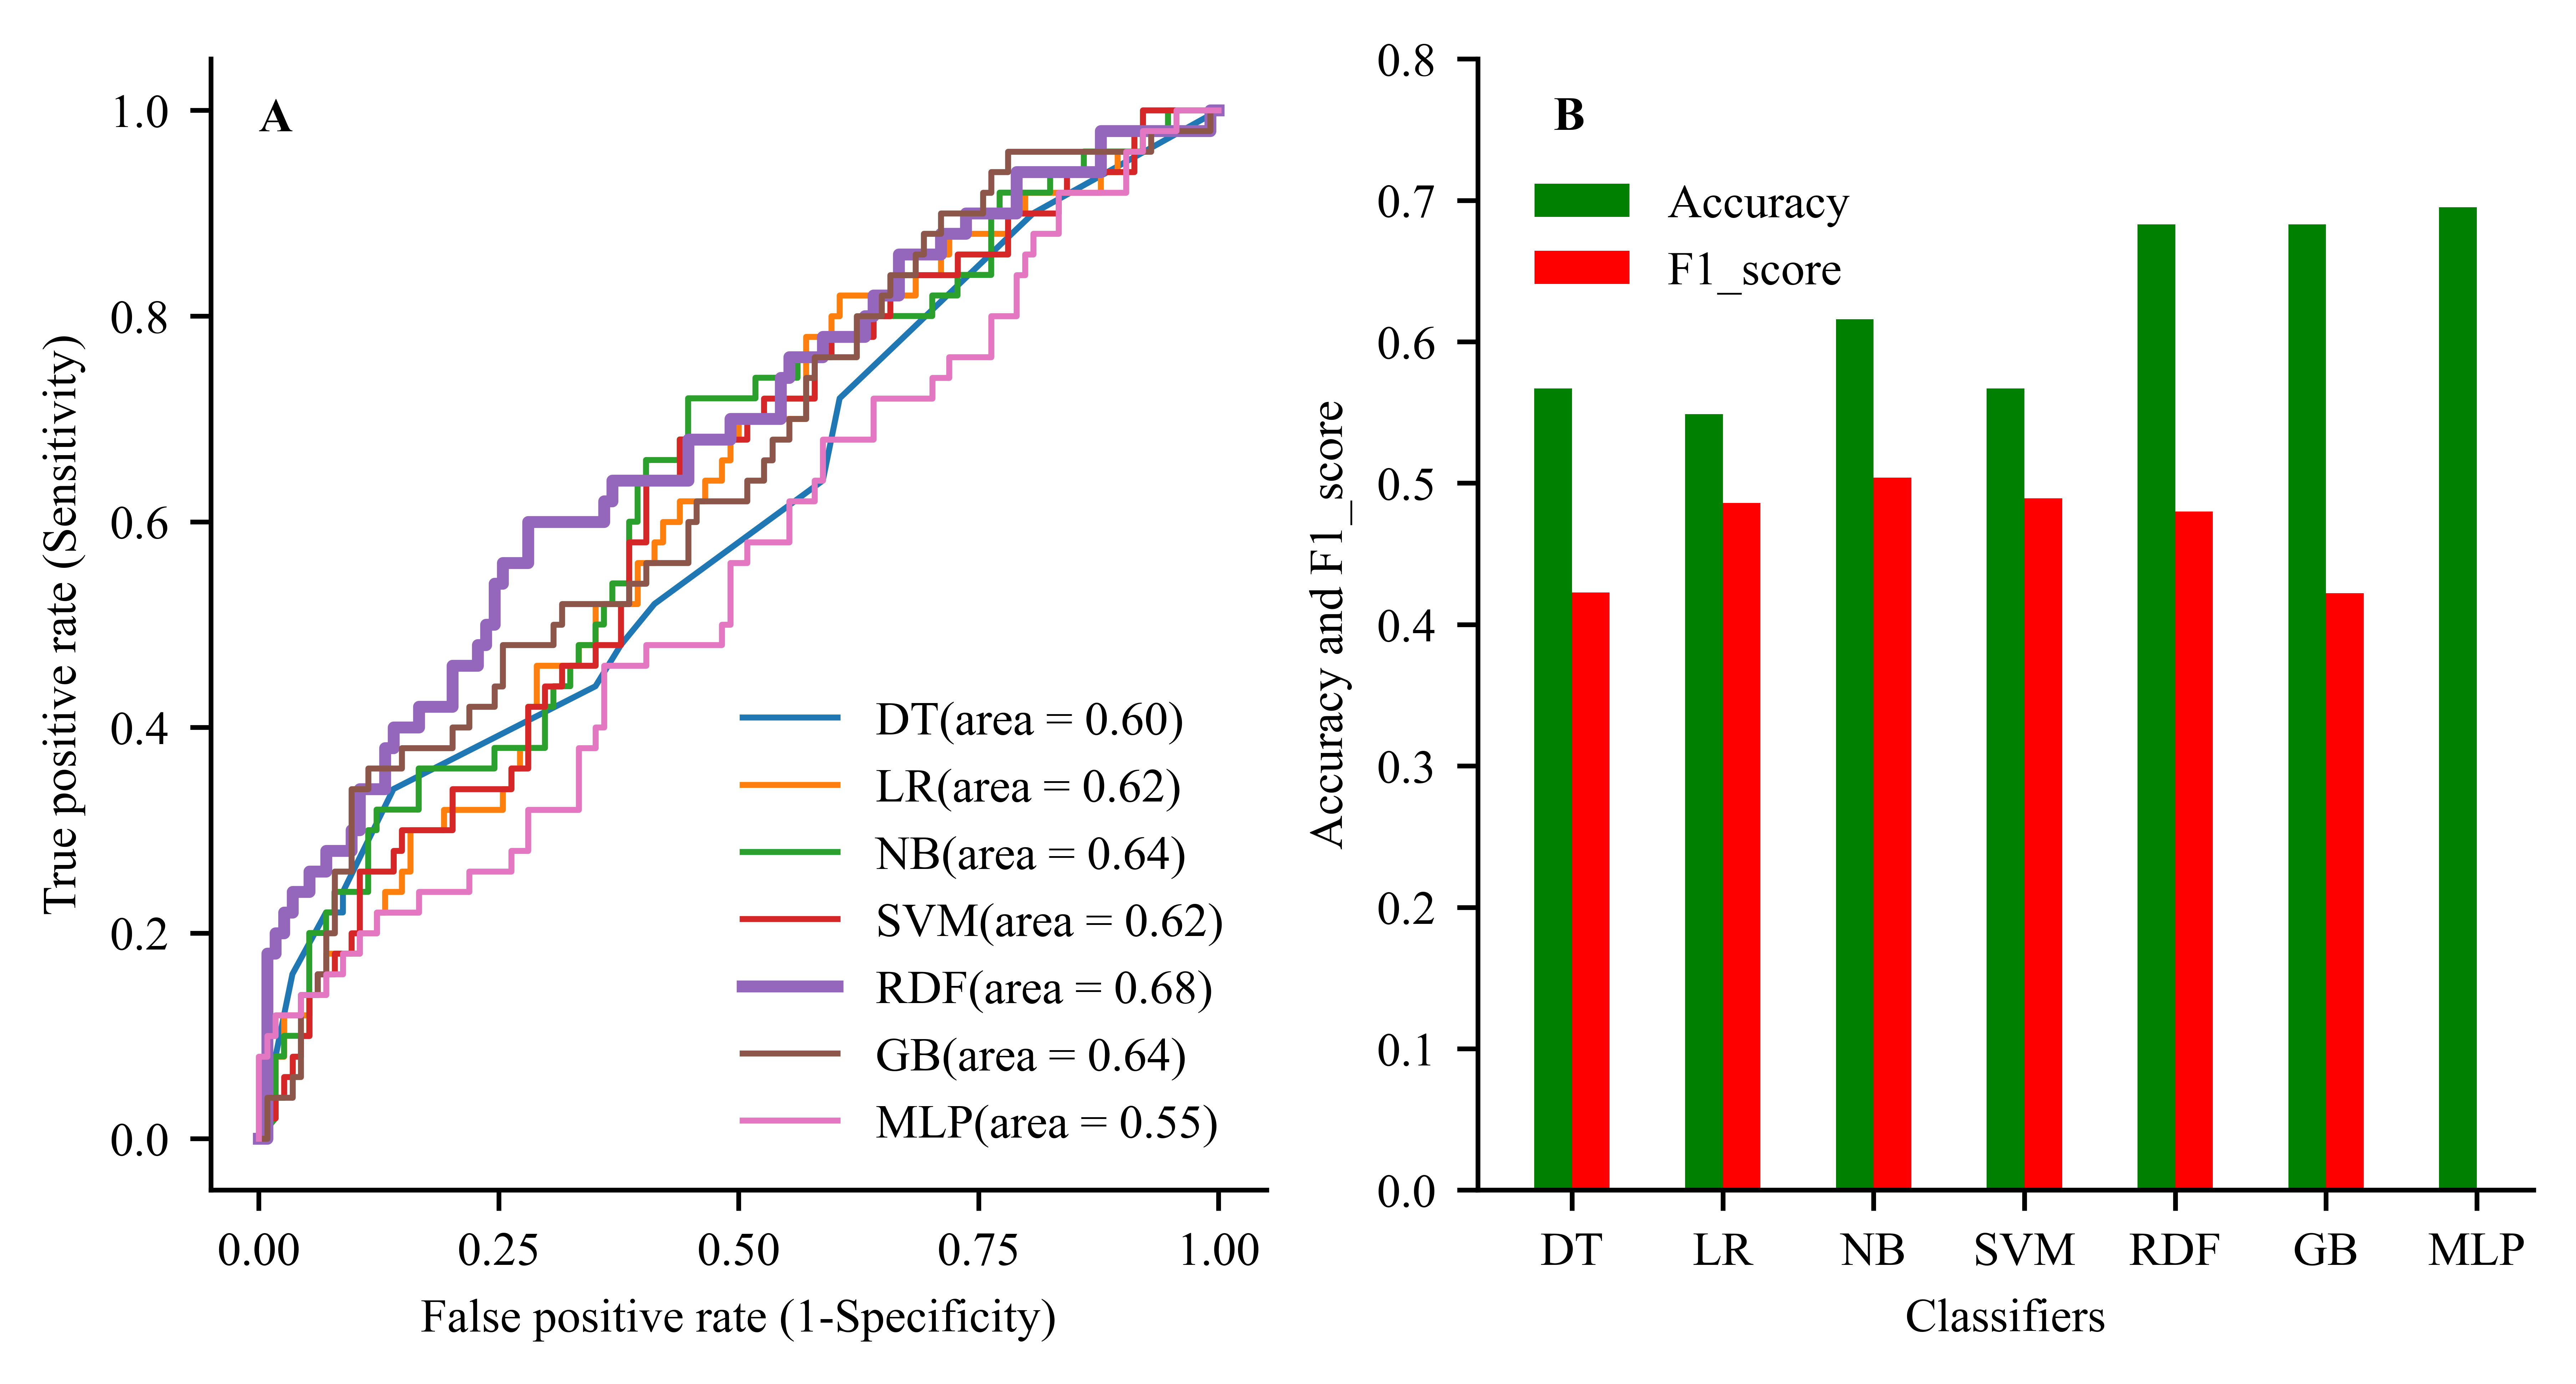

In [27]:
plt.figure(figsize=(7,3.5),dpi=1200)
plt.subplot2grid((1,2),(0,0),colspan=1,rowspan=1)

fpr, tpr, thresholds = roc_curve(y_test, y_probability[0],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='DT(area = {0:.2f})'.format(roc_auc), lw=1)

fpr, tpr, thresholds = roc_curve(y_test, y_probability[1],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='LR(area = {0:.2f})'.format(roc_auc), lw=1)

fpr, tpr, thresholds = roc_curve(y_test, y_probability[2],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='NB(area = {0:.2f})'.format(roc_auc), lw=1)

fpr, tpr, thresholds = roc_curve(y_test, y_probability[3],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='SVM(area = {0:.2f})'.format(roc_auc), lw=1)

fpr, tpr, thresholds = roc_curve(y_test, y_probability[4],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='RDF(area = {0:.2f})'.format(roc_auc), lw=2)

fpr, tpr, thresholds = roc_curve(y_test, y_probability[5],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='GB(area = {0:.2f})'.format(roc_auc), lw=1)

fpr, tpr, thresholds = roc_curve(y_test, y_probability[6],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='MLP(area = {0:.2f})'.format(roc_auc), lw=1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks(fontproperties = 'Times New Roman', size = 8)
plt.xticks(fontproperties = 'Times New Roman', size = 8)

plt.text(0,0.98,'A',fontproperties = 'Times New Roman', size = 8,fontweight='bold')
plt.legend(prop={'family':'Times New Roman', 'size' : 8},frameon=False)

plt.xlabel('False positive rate (1-Specificity)',fontdict={'family': 'Times New Roman','size': 8})
plt.ylabel('True positive rate (Sensitivity)',fontdict={'family': 'Times New Roman','size': 8})

#Acc and F1_score in the test cohort
plt.subplot2grid((1,2),(0,1),colspan=1,rowspan=1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


classifiers = ['DT','LR','NB','SVM', 'RDF','GB','MLP']
accuracy = [DT_acc,LR_acc,NB_acc,LinearSVC_acc,RDF_acc,GDB_acc,MLP_acc]
f1_score = [DT_f1,LR_f1,NB_f1,LinearSVC_f1,RDF_f1,GDB_f1,MLP_f1]

size = 7

x = np.arange(2*size)
total_width, n = 1, 2

width = total_width / n

x = (2*np.arange(1,8)-1)

plt.bar(x, accuracy,  width=width, label='Accuracy',color='g')
plt.bar(x+width, f1_score,width=width, label='F1_score',color='r')


#plt.title('comparisoin of developed models',fontdict={'family': 'Times New Roman','size': 20})
plt.xlabel('Classifiers',fontdict={'family': 'Times New Roman','size': 8})
plt.ylabel('Accuracy and F1_score',fontdict={'family': 'Times New Roman','size': 8})

plt.xlim([0.0, 14])
plt.ylim([0, 0.8])

plt.yticks(fontproperties = 'Times New Roman', size = 8)
plt.xticks(x+width/2, classifiers,fontproperties = 'Times New Roman', size = 8)

plt.text(1,0.75,'B',fontproperties = 'Times New Roman', size = 8,fontweight='bold')

#plt.legend(prop={'family':'Times New Roman', 'size' : 18})
plt.legend(loc=(0.5/14,0.62/0.8),prop={'family':'Times New Roman', 'size' : 8},frameon=False)

#plt.savefig('pic3.jpg',dpi=1200)
plt.show()